In [1]:
# clear all values
%reset -f

In [2]:
import os
import subprocess

import numpy as np
import requests
import time
import concurrent.futures
import matplotlib.pyplot as plt

In [3]:
def plot_data(data,num_requests, this_ip,title='Response Time by API Endpoint and Server', ylabel='Response Time (s)', extra_title=None):
    # add the number of tirals to the extra title   
    extra_title = f"{num_requests} Trials"

    # if this server is in the list, add the location to the extra title
    location = None
    for dns, ip in server_list:
        if this_ip in ip:
            extra_title += f" - {dns.split('.')[1]}"
    if location is None:
        extra_title += f" - Leuven"

    # extract the server names and API endpoints
    servers = list(data[list(data.keys())[0]].keys())
    endpoints = list(data.keys())

    # create an array of the data
    values = np.zeros((len(endpoints), len(servers)))
    for i, endpoint in enumerate(endpoints):
        for j, server in enumerate(servers):
            values[i, j] = data[endpoint][server]

    # plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    opacity = 0.8
    index = np.arange(len(endpoints))
    for i, server in enumerate(servers):
        country = server.split('.')[1]
        ax.bar(index + i * bar_width, values[:, i], bar_width, alpha=opacity, label=country )

    full_title = title
    if extra_title is not None:
        full_title = f"{title} - {extra_title}"

    ax.set_xlabel('API Endpoints')
    ax.set_ylabel(ylabel)
    ax.set_title(full_title)
    ax.set_xticks(index + bar_width * (len(servers) - 1) / 2)
    ax.set_xticklabels(endpoints)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig, ax

def send_rest(url, method, payload=None):
    try:
        if method == "GET":
            response = requests.get(url)
        elif method == "POST":
            response = requests.post(url, json=payload)
        elif method == "PUT":
            response = requests.put(url, json=payload)
        elif method == "DELETE":
            response = requests.delete(url)
        else:
            raise ValueError(f"Invalid method {method}")
    except:
        print(f"Request failed: {url}")
        return None
    return response


def concurrent_test(dns, request_list, num_requests):
    # print server name
    server = f"http://{dns}:{rest_port}"
    country = server.split('.')[1]
    print(f"Server: {country}")
    # test every request
    response_times_dict = {}
    for request in request_list: 
        url, method, *args = request
        payload = args[0] if args else None
        # send requests concurrently
        with concurrent.futures.ThreadPoolExecutor() as executor:
            response_times = []
            for i in range(num_requests):
                start_time = time.perf_counter()
                response = send_rest(server + url, method, payload)
                end_time = time.perf_counter()
                response_time = end_time - start_time
                response_times.append(response_time)
            if url in response_times_dict:
                response_times_dict[url].extend(response_times)
            else:
                response_times_dict[url] = round(sum(response_times),3)
            # total time rounded to 3 decimal places
            total_time = round(sum(response_times), 3)
            
            print(f"URL: {url}, Method: {method}, Total Response Time: {total_time}")

    return response_times_dict

In [4]:
server_list = [
    ('alnike.japaneast.cloudapp.azure.com', '20.210.110.130'),
    ('uswest-thiers.westus3.cloudapp.azure.com', '20.106.100.68'),
    ('useast-lennart.eastus2.cloudapp.azure.com', '20.1.139.66'), 
    ('dapps.westeurope.cloudapp.azure.com', '98.71.185.120')
]

num_requests = 1
rest_port = 8081
this_ip = requests.get('https://api.ipify.org').text

rest_request_list = [
    ['/rest/order', 'POST', {'address': '123 Main St', 'meals': ['Portobello', 'Portobello']}],
    ['/rest/meals', 'GET'],
    ['/rest/largest-meal', 'GET'],
    ['/rest/cheapest-meal', 'GET']
]

response_times_dict = {}

for dns, ip in server_list:
    # if this is the current server, skip
    if ip == this_ip: continue

    # test REST
    response_times = concurrent_test(dns, rest_request_list, num_requests)
    
    for url, times in response_times.items():
        if url not in response_times_dict:
            response_times_dict[url] = {}
        response_times_dict[url][dns] = times
    print('\n')

Server: japaneast
URL: /rest/order, Method: POST, Total Response Time: 0.586
URL: /rest/meals, Method: GET, Total Response Time: 0.459
URL: /rest/largest-meal, Method: GET, Total Response Time: 0.451
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 0.448


Server: westus3
Request failed: http://uswest-thiers.westus3.cloudapp.azure.com:8081/rest/order
URL: /rest/order, Method: POST, Total Response Time: 0.172
Request failed: http://uswest-thiers.westus3.cloudapp.azure.com:8081/rest/meals
URL: /rest/meals, Method: GET, Total Response Time: 0.158
Request failed: http://uswest-thiers.westus3.cloudapp.azure.com:8081/rest/largest-meal
URL: /rest/largest-meal, Method: GET, Total Response Time: 0.244
Request failed: http://uswest-thiers.westus3.cloudapp.azure.com:8081/rest/cheapest-meal
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 0.151


Server: eastus2
URL: /rest/order, Method: POST, Total Response Time: 0.213
URL: /rest/meals, Method: GET, Total Response Time: 0.20

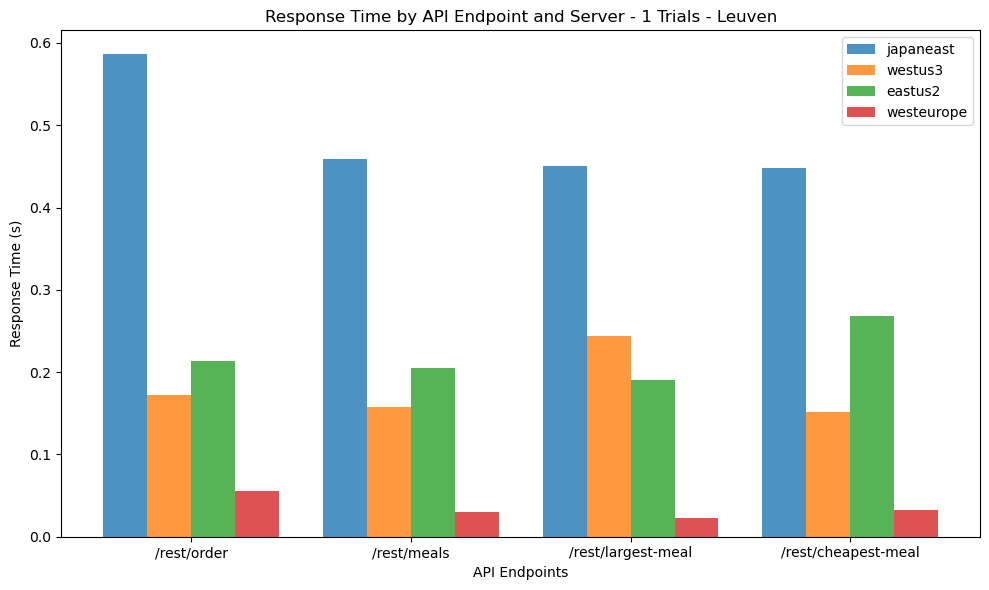

In [5]:
plot_data(response_times_dict, num_requests, this_ip, extra_title=None);